In [112]:
#import stellargraph as sg
#from stellargraph.data import EdgeSplitter
#from stellargraph.mapper import FullBatchLinkGenerator
#from stellargraph.layer import GCN, LinkEmbedding
#from tensorflow import keras
#from sklearn import preprocessing, feature_extraction, model_selection

#from stellargraph import globalvar
#from stellargraph import datasets

In [159]:
from IPython.display import display, HTML
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

# Part 1: Industry Analysis

In [226]:
csv_filename = 'ransomware_mitre_techniques.csv'
rw_df = pd.read_csv(csv_filename)
rw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Ransomware            35 non-null     object
 1   Report                35 non-null     object
 2   Reconassiance         34 non-null     object
 3   Resource Development  4 non-null      object
 4   Initial Access        24 non-null     object
 5   Execution             23 non-null     object
 6   Persistence           18 non-null     object
 7   Privilege Escalation  17 non-null     object
 8   Defense Evasion       25 non-null     object
 9   Credential Access     14 non-null     object
 10  Discovery             22 non-null     object
 11  Lateral Movement      18 non-null     object
 12  Collection            2 non-null      object
 13  Command and Control   11 non-null     object
 14  Exfiltration          7 non-null      object
 15  Impact                29 non-null     obje

### Basic data analysis

In [174]:
rw_tactics = rw_df.columns.values.tolist()[2:]

In [227]:
# Create a table of tactic and technique for each ransomware
rw_mod_df = pd.DataFrame(columns = ['Ransomware','Tactic','Technique'])
for index, row in rw_df.iterrows():
    for tactic in rw_tactics:
        if pd.notna(row[tactic]) and row[tactic].strip() != '':
            temp_df = pd.DataFrame([[row['Ransomware'], tactic, row[tactic]]], columns=['Ransomware','Tactic','Technique'])
            
            rw_mod_df = pd.concat([rw_mod_df,temp_df])
            
rw_mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 0 to 0
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ransomware  217 non-null    object
 1   Tactic      217 non-null    object
 2   Technique   217 non-null    object
dtypes: object(3)
memory usage: 6.8+ KB


In [259]:
# Put each technique in separate row
rw_mod_df["Technique"] = rw_mod_df["Technique"].str.split(",")
rw_mod_df = rw_mod_df.explode("Technique")
rw_mod_df['Technique'] = rw_mod_df['Technique'].str.strip()
rw_mod_df['Tactic-Technique'] = rw_mod_df.apply(lambda row: row['Tactic'] + ':' + row['Technique'], axis=1)
rw_mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464 entries, 0 to 0
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Ransomware        464 non-null    object
 1   Tactic            464 non-null    object
 2   Technique         464 non-null    object
 3   Tactic-Technique  464 non-null    object
dtypes: object(4)
memory usage: 18.1+ KB


In [125]:
rw_mod_df.head()

,Ransomware,Tactic,Technique,Tactic-Technique
0,Alphv (Blackcat),Initial Access,Exploit Public-Facing Application,Initial Access:Exploit Public-Facing Application
0,Alphv (Blackcat),Initial Access,Phishing,Initial Access:Phishing
0,Alphv (Blackcat),Lateral Movement,Remote Services,Lateral Movement:Remote Services
0,Alphv (Blackcat),Command and Control,Remote Access Software,Command and Control:Remote Access Software
0,Alphv (Blackcat),Impact,Data Encrypted for Impact,Impact:Data Encrypted for Impact


In [164]:
## Utility function to wrap text labels

import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

#### Plot 1a

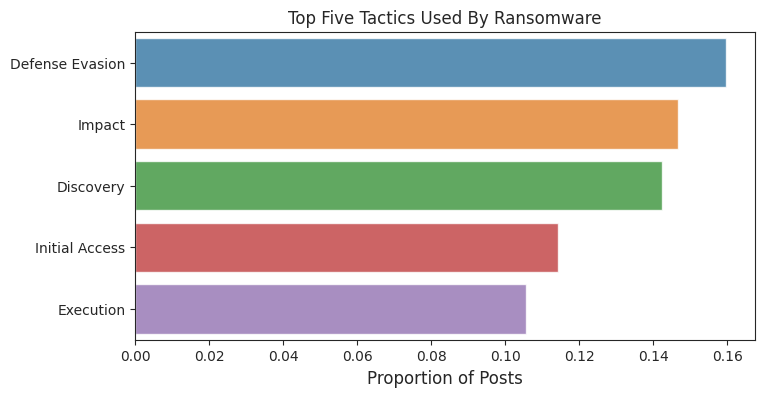

In [255]:
# Top 5 tactics
tactics_count = rw_mod_df['Tactic'].value_counts(normalize=True)
#tnq_count = rw_mod_df['Technique'].value_counts(normalize=True)
plt.figure(figsize=(8,4))
sns.set_style("ticks")
sns.color_palette("Paired", 9)
sns.barplot(x=tactics_count[:5,].values, y=tactics_count[:5,].index, alpha=0.8)
plt.title('Top Five Tactics Used By Ransomware')
#plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Proportion of Posts', fontsize=12)
plt.show()

In [221]:
tactics_gp_counts = (rw_mod_df.groupby(['Tactic','Technique'])).size().reset_index(name='counts')
total_count = tactics_gp_counts['counts'].sum()
tactics_gp_counts['counts'] = tactics_gp_counts['counts'].div(total_count)
tactics_gp_counts_top5 = tactics_gp_counts.sort_values(by=['counts'], ascending=False)[:5]
tactics_gp_counts_top5

,Tactic,Technique,counts
74,Impact,Data Encrypted for Impact,0.058190
57,Execution,Command and Scripting Interpreter,0.043103
77,Impact,Inhibit System Recovery,0.038793
30,Defense Evasion,Impair Defenses,0.036638
84,Initial Access,Phishing,0.030172


#### Plot 1b: Tactics and Techniques in the same plot

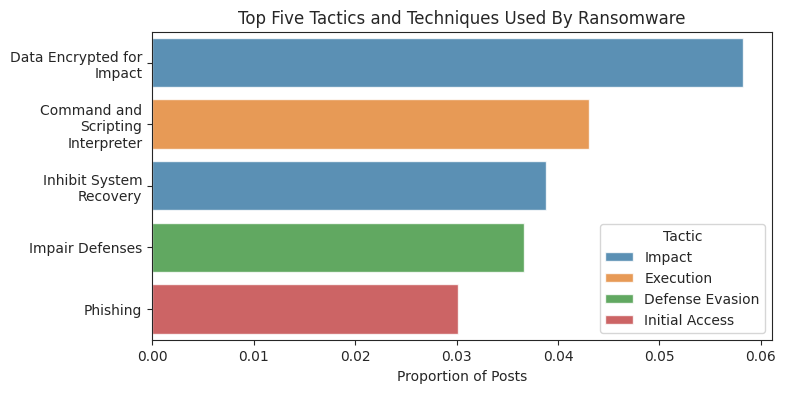

In [256]:
# top 5 techniques and tactic
plt.figure(figsize=(8,4))
ax = plt.gca()
#sns.set_style("ticks")
sns.color_palette("Paired", 9)
sns.barplot(data=tactics_gp_counts_top5,x='counts', y='Technique', hue='Tactic', alpha=0.8, dodge=False)
ax.set(
 title ='Top Five Tactics and Techniques Used By Ransomware',
 xlabel = 'Proportion of Posts',
 ylabel = None
)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
wrap_labels(ax, 20)
plt.show()

#### Plot 1c

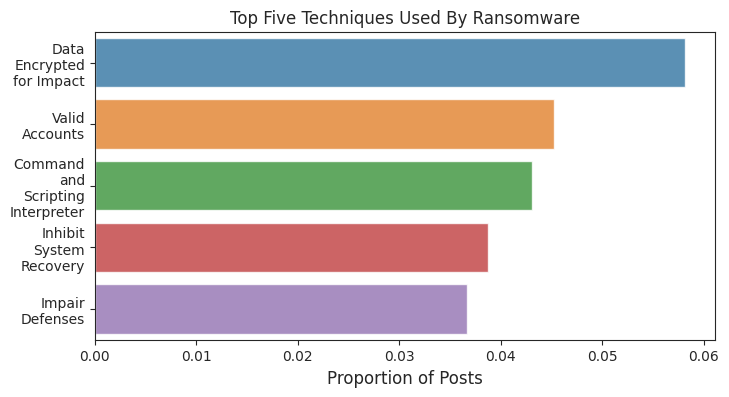

In [257]:
# Top 5 techniques
tnq_count = rw_mod_df['Technique'].value_counts(normalize=True)
plt.figure(figsize=(8,4))
ax = plt.gca()
sns.set_style("ticks")
sns.color_palette("Paired", 9)
sns.barplot(x=tnq_count[:5,].values, y=tnq_count[:5,].index, alpha=0.8)
plt.title('Top Five Techniques Used By Ransomware')
plt.xlabel('Proportion of Posts', fontsize=12)
wrap_labels(ax, 10)
plt.show()

#### Plot 1d (Similar to 1b)

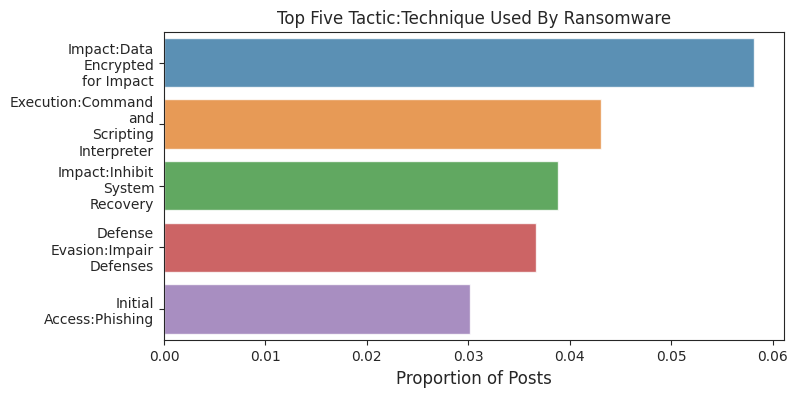

In [260]:
# Top 5 tactic/techniques
tctnq_count = rw_mod_df['Tactic-Technique'].value_counts(normalize=True)
plt.figure(figsize=(8,4))
ax = plt.gca()

sns.set_style("ticks")
sns.color_palette("Paired", 9)
sns.barplot(x=tctnq_count[:5,].values, y=tctnq_count[:5,].index, alpha=0.8)
plt.title('Top Five Tactic:Technique Used By Ransomware')
#plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Proportion of Posts', fontsize=12)
wrap_labels(ax, 10)

plt.show()

In [214]:
#rw_mod_df['Tactic-Technique'].value_counts()

# Part 2: Datasets

### Training data

In [215]:
#csv_filename = 'sample_hf.csv'
csv_filename = 'hf_650_topic_technique.csv'
hf_df_raw = pd.read_csv(csv_filename)
hf_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032 entries, 0 to 1031
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Topic      1032 non-null   object
 1   Technique  538 non-null    object
 2   Tactic     437 non-null    object
 3   Thread     1032 non-null   object
dtypes: object(4)
memory usage: 32.4+ KB


In [216]:
hf_df_raw["Technique"] = hf_df_raw["Technique"].str.split(",")
hf_df_raw["Tactic"] = hf_df_raw["Tactic"].str.split(",")
hf_df_raw = hf_df_raw.explode("Technique")
hf_df_raw = hf_df_raw.explode("Tactic")
hf_df_raw[['Tactic']] = hf_df_raw[['Tactic']].fillna(value='NA')
hf_df_raw = hf_df_raw[hf_df_raw['Technique'].notna()]
hf_df_raw['Technique'] = hf_df_raw['Technique'].str.strip()
hf_df_raw['Tactic'] = hf_df_raw['Tactic'].str.strip()
hf_df_raw['Tactic-Technique'] = hf_df_raw.apply(lambda row: row['Tactic'] + ':' + row['Technique'], axis=1)

In [134]:
hf_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 1030
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Topic             648 non-null    object
 1   Technique         648 non-null    object
 2   Tactic            648 non-null    object
 3   Thread            648 non-null    object
 4   Tactic-Technique  648 non-null    object
dtypes: object(5)
memory usage: 30.4+ KB


In [101]:
hf_df_raw.head()

,Topic,Technique,Tactic,Thread,Tactic-Technique
0,Gmail account hack will play for it,Compromise Accounts,Initial Access,https://hackforums.net/showthread.php?tid=6105591,Initial Access:Compromise Accounts
1,[Hack Mac/Linux] Concealing payloads inside im...,Obfuscated files or information,Defense evasion,https://hackforums.net/showthread.php?tid=6105744,Defense evasion:Obfuscated files or information
7,[TUT] SQLMap Usage,Exploitation for Client Execution,Resource Development,https://hackforums.net/showthread.php?tid=6105055,Resource Development:Exploitation for Client E...
7,[TUT] SQLMap Usage,Exploitation for Client Execution,Execution,https://hackforums.net/showthread.php?tid=6105055,Execution:Exploitation for Client Execution
8,[TUT] Hacking a WiFi Network with Kali Linux.,Brute Force,Credential Access,https://hackforums.net/showthread.php?tid=6105042,Credential Access:Brute Force


### Plot value distribution

In [217]:
hf_df = hf_df_raw[["Topic","Technique","Tactic",'Tactic-Technique']]

In [231]:
hf_df['Technique'].value_counts()

Brute Force                             60
Compromise Accounts                     56
Obtain Capabilities                     34
Phishing                                25
Remote Access Software                  23
                                        ..
System Shutdown/Reboot                   1
Native API                               1
Exploit Public Facing application        1
Boot or Logon Initialization Scripts     1
Gather Victim Org Information            1
Name: Technique, Length: 106, dtype: int64

#### Plot 2A: Top HF Tactics and Techniques in the same plot

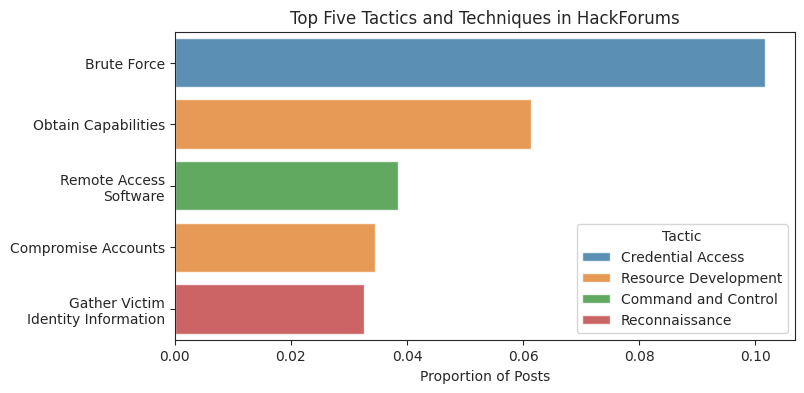

In [261]:
# Top 5 tactic/techniques

hf_df_gp_counts = (hf_df.groupby(['Tactic','Technique'])).size().reset_index(name='counts')
hf_df_gp_counts = hf_df_gp_counts[hf_df_gp_counts['Tactic'] != 'NA']
total_count = hf_df_gp_counts['counts'].sum()
hf_df_gp_counts['counts'] = hf_df_gp_counts['counts'].div(total_count)
hf_df_gp_counts_top5 = hf_df_gp_counts.sort_values(by=['counts'], ascending=False)[:5]


#hf_df_count = hf_df['Tactic-Technique'].value_counts(normalize=True)
#plt.figure(figsize=(8,4))
#ax = plt.gca()
#sns.set_style("ticks")
#sns.color_palette("Paired", 9)
#sns.barplot(x=hf_df_count[:5,].values, y=hf_df_count[:5,].index, alpha=0.8)
#plt.title('Top Five Tactic:Technique in HackForum Posts')
#plt.xlabel('Proportion', fontsize=12)
#wrap_labels(ax, 25)
#plt.show()


plt.figure(figsize=(8,4))
ax = plt.gca()
sns.color_palette("Paired", 9)
sns.barplot(data=hf_df_gp_counts_top5,x='counts', y='Technique', hue='Tactic', alpha=0.8, dodge=False)
ax.set(
 title ='Top Five Tactics and Techniques in HackForums',
 xlabel = 'Proportion of Posts',
 ylabel = None
)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
wrap_labels(ax, 20)
plt.show()

In [233]:
#hf_df_gp_counts_top5

### Test Data: From 0x00sec

In [237]:
## Forum: 0x00sec, Category: Exploit development 

csv_00sec = '0x00sec_data.csv'

df_00sec = pd.read_csv(csv_00sec)
df_00sec.head()

,Topic,Thread,Tactic,Technique
0,XORCry - a simple python ransomware,/t/xorcry-a-simple-python-ransomware/31148/2,Impact,Data Encrypted for Impact
1,Python and Malware: Writing a simple wiper mal...,/t/python-and-malware-writing-a-simple-wiper-m...,Privilege Escalation,Abuse Elevation Control Mechanism
2,Writing a simple rootkit for linux,/t/writing-a-simple-rootkit-for-linux/29034,Defense Evasion,Rootkit
3,Awesome malware development resources,/t/awesome-malware-development-resources/29020,NaN,NaN
4,Reviving DotNetToJScript to bypass AVs,/t/reviving-dotnettojscript-to-bypass-avs/30230,Defense Evasion,Obfuscated Files or Information


In [238]:
df_00sec["Technique"] = df_00sec["Technique"].str.split(",")
df_00sec["Tactic"] = df_00sec["Tactic"].str.split(",")
df_00sec = df_00sec.explode("Technique")
df_00sec = df_00sec.explode("Tactic")

df_00sec = df_00sec[df_00sec['Technique'].notna()]
df_00sec['Technique'] = df_00sec['Technique'].str.strip()
df_00sec['Tactic'] = df_00sec['Tactic'].str.strip()

#df_00sec['Tactic-Technique'] = df_00sec.apply(lambda row: row['Tactic'] + ':' + row['Technique'], axis=1)

df_00sec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 203
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Topic      138 non-null    object
 1   Thread     138 non-null    object
 2   Tactic     138 non-null    object
 3   Technique  138 non-null    object
dtypes: object(4)
memory usage: 5.4+ KB


### Plot 3A: 0x00sec Top Tactics and Techniques in the Exploit Development category

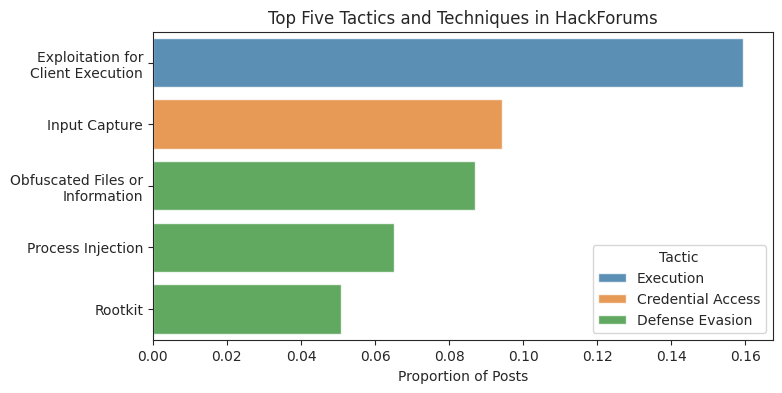

In [240]:
# Top 5 tactic/techniques
df_00sec_gp_counts = (df_00sec.groupby(['Tactic','Technique'])).size().reset_index(name='counts')
df_00sec_gp_counts = df_00sec_gp_counts[df_00sec_gp_counts['Tactic'] != 'NA']
total_count = df_00sec_gp_counts['counts'].sum()
df_00sec_gp_counts['counts'] = df_00sec_gp_counts['counts'].div(total_count)
df_00sec_gp_counts_top5 = df_00sec_gp_counts.sort_values(by=['counts'], ascending=False)[:5]

plt.figure(figsize=(8,4))
ax = plt.gca()
sns.color_palette("Paired", 9)
sns.barplot(data=df_00sec_gp_counts_top5,x='counts', y='Technique', hue='Tactic', alpha=0.8, dodge=False)
ax.set(
 title ='Top Five Tactics and Techniques in HackForums',
 xlabel = 'Proportion of Posts',
 ylabel = None
)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
wrap_labels(ax, 20)
plt.show()

### Compare training versus test distributions

In [242]:
## Do counts have the same distribution in both datasets?
## User K-S statistics to determine whether category counts in HF and 0x00sec datasets have the same distribution.

from scipy.stats import ks_2samp
import numpy as np

nx_df_00sec = df_00sec[["Topic","Technique","Tactic"]]

techniques_hf = hf_df['Technique'].to_numpy()
techniques_00sec = nx_df_00sec['Technique'].to_numpy()

tactics_hf = hf_df['Tactic'].to_numpy()
tactics_00sec = nx_df_00sec['Tactic'].to_numpy()

print(ks_2samp(techniques_hf, techniques_00sec))
print(ks_2samp(tactics_hf, tactics_00sec))

KstestResult(statistic=0.18914385399892647, pvalue=0.00048527025752508074)
KstestResult(statistic=0.35238862050456254, pvalue=4.265851615329464e-13)


# Part 3: Graph Analysis

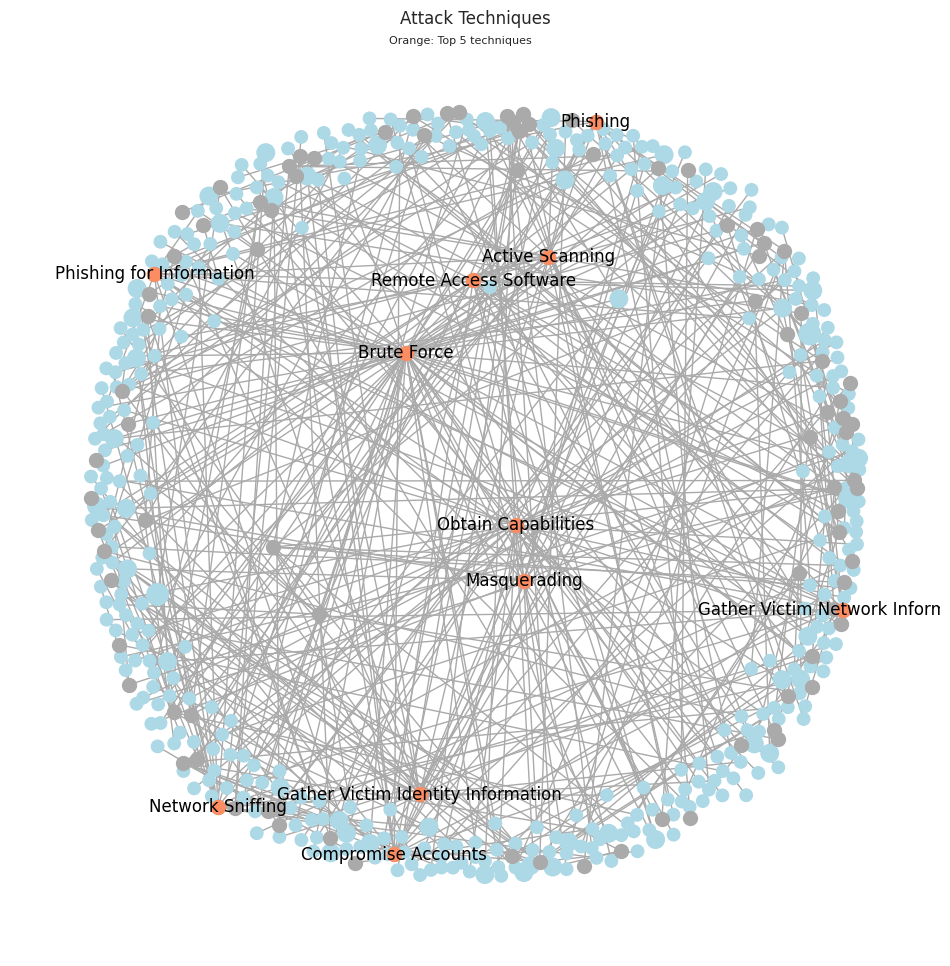

In [263]:
plt.figure(figsize=(12, 12))

# 1. Create the graph
g = nx.from_pandas_edgelist(hf_df, source='Topic', target='Technique') 

# 2. Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=50,k=30/math.sqrt(g.order()))

# 3. Draw the parts we want
nx.draw_networkx_edges(g, layout, edge_color='#AAAAAA')

topics = [node for node in g.nodes() if node in hf_df['Topic'].unique()]
size = [g.degree(node) * 80 for node in g.nodes() if node in hf_df['Topic'].unique()]
nx.draw_networkx_nodes(g, layout, nodelist=topics, node_size=size, node_color='lightblue')

techniques = [node for node in g.nodes() if node in hf_df['Technique'].unique()]
nx.draw_networkx_nodes(g, layout, nodelist=techniques, node_size=100, node_color='#AAAAAA')

high_degree_topics = [node for node in g.nodes() if node in hf_df['Topic'].unique() and g.degree(node) > 20]
#nx.draw_networkx_nodes(g, layout, nodelist=high_degree_topics, node_size=100, node_color='#00008b')

#high_degree_tactic = [node for node in g.nodes() if node in nx_df['Tactic'].unique() and g.degree(node) > 20]
#nx.draw_networkx_nodes(g, layout, nodelist=high_degree_tactic, node_size=100, node_color='#00008b')

high_degree_techniques = [node for node in g.nodes() if node in hf_df['Technique'].unique() and g.degree(node) > 8]
nx.draw_networkx_nodes(g, layout, nodelist=high_degree_techniques, node_size=100, node_color='#fc8d62')

technique_dict = dict(zip(techniques, techniques))
#nx.draw_networkx_labels(g, layout, labels=technique_dict)
hd_technique_dict = dict(zip(high_degree_techniques, high_degree_techniques))

nx.draw_networkx_labels(g, layout, labels=hd_technique_dict)

# 4. Turn off the axis
plt.axis('off')
plt.title("Attack Techniques",fontsize=12,ha='center')
plt.figtext(.5,.87,'Orange: Top 5 techniques',fontsize=8,ha='center')

# 5. Tell matplotlib to show it
plt.show()


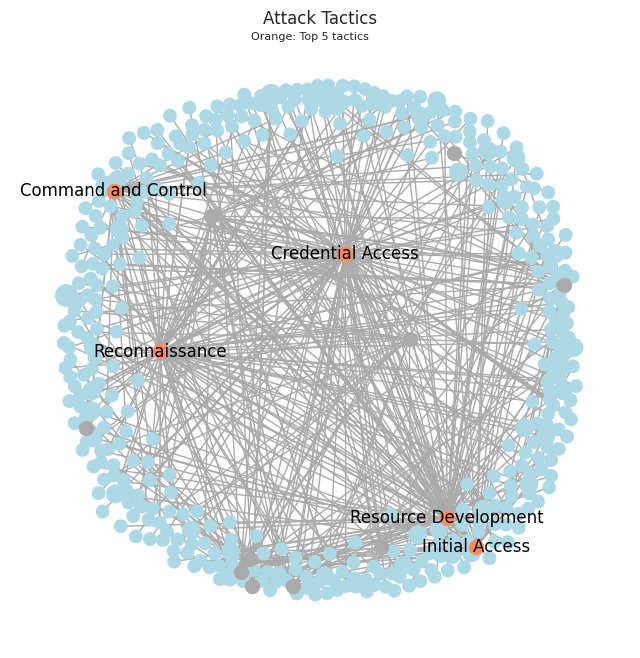

In [269]:
# Plot Tactics

plt.figure(figsize=(8, 8))

## Remove NAs
hf_df = hf_df[hf_df['Tactic'] != 'NA']

# 1. Create the graph
g = nx.from_pandas_edgelist(hf_df, source='Topic', target='Tactic') 

# 2. Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=30,k=28/math.sqrt(g.order()))

# 3. Draw the parts we want
nx.draw_networkx_edges(g, layout, edge_color='#AAAAAA')

topics = [node for node in g.nodes() if node in hf_df['Topic'].unique()]
size = [g.degree(node) * 80 for node in g.nodes() if node in hf_df['Topic'].unique()]
nx.draw_networkx_nodes(g, layout, nodelist=topics, node_size=size, node_color='lightblue')

tactics = [node for node in g.nodes() if node in hf_df['Tactic'].unique()]
nx.draw_networkx_nodes(g, layout, nodelist=tactics, node_size=100, node_color='#AAAAAA')

#high_degree_topics = [node for node in g.nodes() if node in hf_df['Topic'].unique() and g.degree(node) > 2]
#nx.draw_networkx_nodes(g, layout, nodelist=high_degree_topics, node_size=100, node_color='#00008b')

high_degree_tactic = [node for node in g.nodes() if node in hf_df['Tactic'].unique() and g.degree(node) > 28]
nx.draw_networkx_nodes(g, layout, nodelist=high_degree_tactic, node_size=100, node_color='#fc8d62')

technique_dict = dict(zip(tactics, tactics))
#nx.draw_networkx_labels(g, layout, labels=technique_dict)
hd_tactic_dict = dict(zip(high_degree_tactic, high_degree_tactic))

nx.draw_networkx_labels(g, layout, labels=hd_tactic_dict)

# 4. Turn off the axis
plt.axis('off')
plt.title("Attack Tactics",fontsize=12,ha='center')
plt.figtext(.5,.87,'Orange: Top 5 tactics',fontsize=8,ha='center')

# 5. Tell matplotlib to show it
plt.show()




In [251]:
hf_df['Tactic'].value_counts()

Credential Access       107
Reconnaissance           80
Resource Development     76
Initial Access           56
Defense evasion          33
Command and Control      33
Impact                   27
Discovery                27
Execution                23
Collection               18
Defense Evasion          18
Privilege Escalation     12
Persistence               9
Exfiltration              1
Control and Command       1
Name: Tactic, dtype: int64

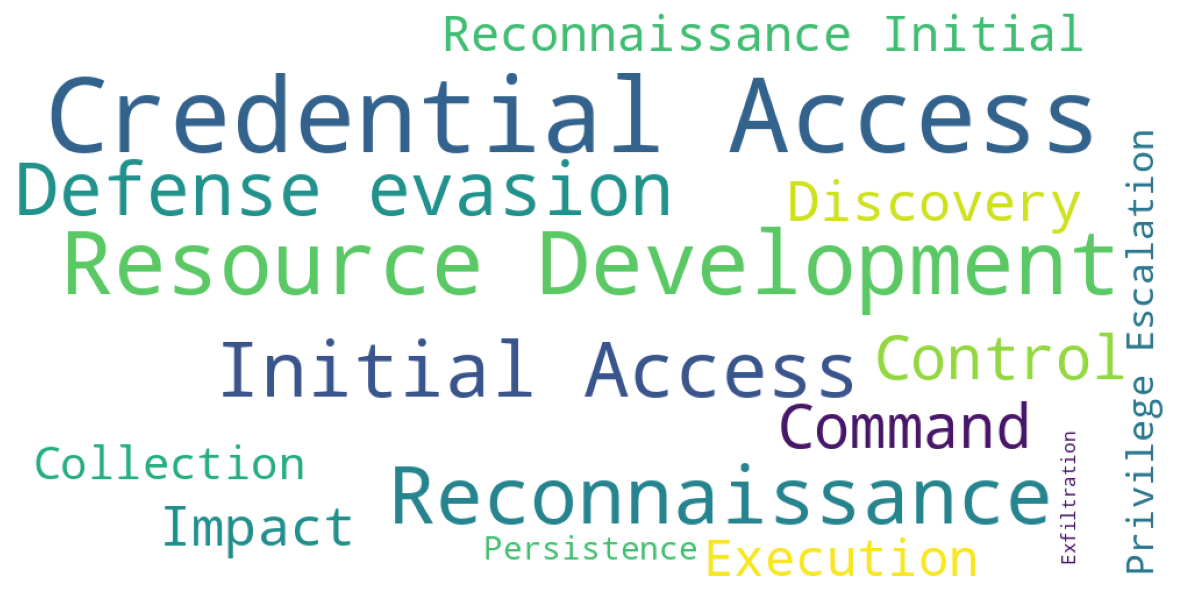

In [252]:
from wordcloud import WordCloud

tactics_string = hf_df["Tactic"].astype(str).to_string()
#convert list to string and generate
#unique_string=(" ").join(my_list)
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate(tactics_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

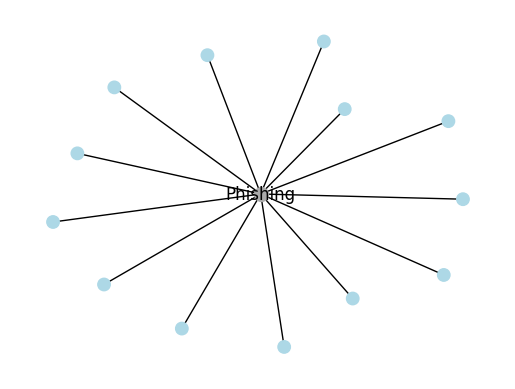

In [254]:
sg = nx.from_pandas_edgelist(hf_df[hf_df['Technique'] == 'Phishing'], source='Topic', target='Technique')
layout = nx.spring_layout(sg)

nx.draw_networkx_edges(sg, layout)
topics = [node for node in sg.nodes() if node in hf_df['Topic'].unique()]
size = [sg.degree(node) * 80 for node in sg.nodes() if node in hf_df['Topic'].unique()]
nx.draw_networkx_nodes(sg, layout, nodelist=topics, node_size=size, node_color='lightblue')
techniques = [node for node in sg.nodes() if node in hf_df['Technique'].unique()]
nx.draw_networkx_nodes(sg, layout, nodelist=techniques, node_size=100, node_color='#AAAAAA')
nx.draw_networkx_labels(sg, layout, labels={'Phishing':'Phishing'})
plt.axis('off')
plt.show()
